Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.rai.plotters.rai_plotter
from src.rai.bootstrap.bootstrap import Bootstrap
from src.rai.bootstrap.confidence_interval import ConfidenceInterval
import numpy as np
import pandas as pd

Get data

In [3]:
database = pd.read_csv('https://archive.ics.uci.edu/static/public/29/data.csv')

Exploratory Data Analysis

In [4]:
database.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


In [5]:
database.head()

,VendorName,ModelName,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [6]:
database.tail()

,VendorName,ModelName,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
204,sperry,80/8,124,1000,8000,0,1,8,42,37
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
206,sratus,32,125,2000,8000,0,2,14,52,41
207,wang,vs-100,480,512,8000,32,0,0,67,47
208,wang,vs-90,480,1000,4000,0,0,0,45,25


In [7]:
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB


In [8]:
database.isnull().sum()

VendorName    0
ModelName     0
MYCT          0
MMIN          0
MMAX          0
CACH          0
CHMIN         0
CHMAX         0
PRP           0
ERP           0
dtype: int64

Process data

In [9]:
processed_database = database.copy()
processed_database = processed_database.sort_values(by='CACH', ascending=False)

processed_database['CACH']

0      256
156    256
168    160
19     142
31     131
      ... 
84       0
83       0
80       0
76       0
208      0
Name: CACH, Length: 209, dtype: int64

In [10]:
percentiles = [25, 50, 75]

quantiles = np.percentile(processed_database['CACH'], percentiles)

processed_database['group'] = np.select(
    [processed_database['CACH'] <= quantiles[0],
     (processed_database['CACH'] > quantiles[0]) & (processed_database['CACH'] <= quantiles[1]),
     (processed_database['CACH'] > quantiles[1]) & (processed_database['CACH'] <= quantiles[2]),
     (processed_database['CACH'] > quantiles[2]) & (processed_database['CACH'] < processed_database['CACH'].max()),
     processed_database['CACH'] == processed_database['CACH'].max()
    ],  
    ['NOCACH', 'LOW', 'MEDIUM', 'HIGH', 'MAX']
)

processed_database['group'] = pd.Categorical(
    processed_database['group'], 
    categories=['NOCACH', 'LOW', 'MEDIUM', 'HIGH', 'MAX'], 
    ordered=True
)

group_distribution = processed_database.groupby('group', observed=True).size()

group_distribution


group
NOCACH    69
LOW       50
MEDIUM    51
HIGH      37
MAX        2
dtype: int64

Get confidence intervals

{'NOCACH': (32.91290456963693, 33.04716306321331), 'LOW': (39.67906418216623, 39.79192692894489), 'MEDIUM': (93.6610898228612, 93.99701475230223), 'HIGH': (294.7312494241797, 296.51416799323766), 'MAX': (396.6922225565523, 402.56955522122547)}


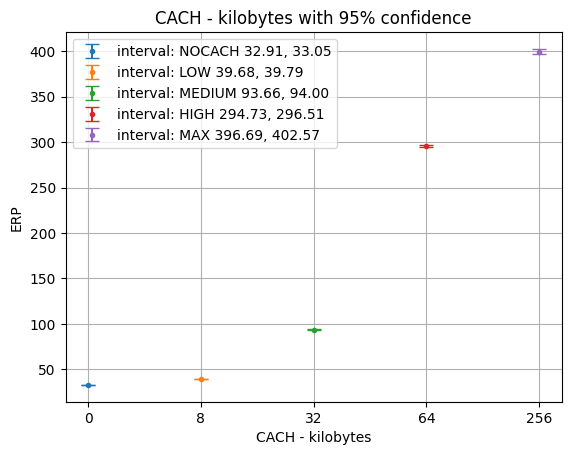

<Figure size 1200x1000 with 0 Axes>

In [11]:
confidence_intervals = {}
n_bootstraps = 9000

for group_name, group in processed_database.groupby('group'):
    erp_values = group['ERP'].values  
    
    bootstrap = Bootstrap(X=erp_values)
    bootstrap.calculate_bootstrap(bootstraps=n_bootstraps, estimator=np.mean)
    
    confidence_interval = ConfidenceInterval(data=bootstrap.theta, alpha=0.05)
    confidence_intervals[group_name] = confidence_interval.interval()

print(confidence_intervals)
src.rai.plotters.rai_plotter.plot_confidence_interval(confidence_intervals, 'CACH - kilobytes', '95%', 'ERP', x_ticks=[0, 8, 32, 64, 256])
